In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/soidme/Dataset/train.csv
/kaggle/input/soidme/Dataset/2015_BOE_Chiu/Subject_06.mat
/kaggle/input/soidme/Dataset/2015_BOE_Chiu/Subject_08.mat
/kaggle/input/soidme/Dataset/2015_BOE_Chiu/Subject_03.mat
/kaggle/input/soidme/Dataset/2015_BOE_Chiu/Subject_02.mat
/kaggle/input/soidme/Dataset/2015_BOE_Chiu/Subject_10.mat
/kaggle/input/soidme/Dataset/2015_BOE_Chiu/Subject_07.mat
/kaggle/input/soidme/Dataset/2015_BOE_Chiu/Subject_09.mat
/kaggle/input/soidme/Dataset/2015_BOE_Chiu/Subject_01.mat
/kaggle/input/soidme/Dataset/2015_BOE_Chiu/Subject_04.mat
/kaggle/input/soidme/Dataset/2015_BOE_Chiu/Subject_05.mat
/kaggle/input/soidme/Dataset/2015_BOE_Chiu/2015_BOE_Chiu/Subject_06.mat
/kaggle/input/soidme/Dataset/2015_BOE_Chiu/2015_BOE_Chiu/Subject_08.mat
/kaggle/input/soidme/Dataset/2015_BOE_Chiu/2015_BOE_Chiu/Subject_03.mat
/kaggle/input/soidme/Dataset/2015_BOE_Chiu/2015_BOE_Chiu/Subject_02.mat
/kaggle/input/soidme/Dataset/2015_BOE_Chiu/2015_BOE_Chiu/Subject_10.mat
/kaggle/input/soidme/

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm import tqdm as tqdm
import torchvision
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import math
import random
import os
import scipy.io as io
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
input_path = os.path.join('/kaggle/input/soidme/Dataset/2015_BOE_Chiu')
subject_path = [os.path.join(input_path, 'Subject_0{}.mat'.format(i)) for i in range(1, 10)] + [os.path.join(input_path, 'Subject_10.mat')]

data_indexes = [10, 15, 20, 25, 28, 30, 32, 35, 40, 45, 50]

width = 284
height = 284
width_out = 196
height_out = 196

In [5]:
def check_for_nonzero(item):
    if torch.count_nonzero(item)!=0:
        return True
    return False
def resize(item,size):
    T = torchvision.transforms.Resize(size=(size,size), 
                                      interpolation=transforms.InterpolationMode.BILINEAR, 
                                      antialias=True)
    return T(item)

In [6]:
class OCTDataset(Dataset):
    def __init__(self, root, transforms, size):
        self.root = root
        self.transforms = transforms
        self.subject_path = [os.path.join(self.root, 'Subject_0{}.mat'.format(i)) for i in range(1, 10)]+[os.path.join(input_path, 'Subject_10.mat')]
        
        self.size = size
        self.images = torch.tensor([])
        self.masks = torch.tensor([])
        self.y = []
        
        self.load_images_and_masks()
        
        print(self.images.size(), self.masks.size())
        
    def __len__(self):
        return len(self.images)
    
    
    def __getitem__(self, idx):
        img = self.images[idx]
        mask = self.masks[idx]
        
        obj_ids = mask.unique()
        obj_ids = obj_ids[1:]

        num_objs = len(obj_ids)
        masks = mask == obj_ids[:, None, None]

        boxes = []
        
        for i in range(num_objs):
            
            pos = torch.nonzero(masks[i])
            mins, _ = torch.min(pos, dim=0)
            maxs, _ = torch.max(pos, dim=0)
            xmin = mins[1]
            ymin = mins[0]
            
            xmax = maxs[1]
            ymax = maxs[0]
            
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(obj_ids, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
            
        return img, target
            
        pass
    
    def load_images_and_masks(self):
        for i in tqdm(range(len(self.subject_path))):  
            
            mat = io.loadmat(self.subject_path[i])
            
            images = np.expand_dims(np.transpose(mat['images'], (2,0,1))/255, 0)
            y = np.transpose(mat['manualFluid1'], (2,0,1))
            masks = np.expand_dims(np.nan_to_num(y),0)
            images = torch.as_tensor(images, dtype=torch.float32)
            masks = torch.as_tensor(masks, dtype=torch.uint8)
            images = resize(images, self.size)
            masks = resize(masks, self.size)
            for idx in range(images.shape[1]):
                
                mask = masks[0][idx]
                if check_for_nonzero(mask):
                    temp1 = images[::, idx, ::]
                    
                    temp2 = masks[0, idx, ::].unsqueeze(0)
                    img = torch.cat([temp1]*3).unsqueeze(0)
                    
                    self.images = torch.cat((self.images, img))
                    self.masks = torch.cat((self.masks, temp2))

In [7]:
OCT = OCTDataset('/kaggle/input/soidme/Dataset/2015_BOE_Chiu', 
                 None, 
                 512)

100%|██████████| 10/10 [00:38<00:00,  3.86s/it]

torch.Size([78, 3, 512, 512]) torch.Size([78, 512, 512])


In [10]:
indices = torch.randperm(len(OCT)).tolist()
train_indices = indices[:-8]
test_indices = indices[-8:]
OCTrain = torch.utils.data.Subset(OCT, train_indices)
OCTest = torch.utils.data.Subset(OCT, test_indices)

## MaskRCNN with ResNet50 Backbone

In [11]:
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 128
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [13]:
model = get_model_instance_segmentation(16)
print('model loaded')

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:00<00:00, 246MB/s]  


model loaded


In [14]:
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [15]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=1e-4)
    # and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')

In [18]:
import torch
from torchvision.ops import box_convert
from torchvision.ops import box_iou
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.roi_heads import paste_masks_in_image

In [21]:
num_epochs = 100
model.train()
loss_list = []
epochs = []


for epoch in tqdm(range(num_epochs)):
    # Shuffle train_indices for each epoch
    random.shuffle(train_indices)
    OCTrain = torch.utils.data.Subset(OCT, train_indices)
    
    total_loss = 0.0
    for images, targets in OCTrain:
        images = [images.to(device)]
        targets = [{k: v.to(device) for k, v in targets.items()}]
        optimizer.zero_grad()
        output = model(images, targets)
        loss = sum(losses for losses in output.values())
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    
    avg_loss = total_loss / len(OCTrain)
    lr_scheduler.step(avg_loss)
    loss_list.append(avg_loss)
    if epoch % 10 == 0:
        epochs.append(epoch)
        loss_list.append(loss.item())

100%|██████████| 100/100 [14:28<00:00,  8.68s/it]


In [23]:
model.eval()
results = []
for images, targets in OCTest:
    with torch.no_grad():
        images = [images.to(device)]
        targets = [{k: v.to(device) for k, v in targets.items()}]
        output = model(images)
    results.append(output)

In [32]:
print("Length of OCTest:", len(OCTest))
print("Length of results:", len(results))

Length of OCTest: 8
Length of results: 8


In [43]:
from scipy.io import loadmat

# Load the MAT file
annots = loadmat('/kaggle/input/soidme/Dataset/2015_BOE_Chiu/Subject_06.mat')

# Get the fluid class labels
fluid_labels1 = annots['manualFluid1']  # Fluid labels from manualFluid1
fluid_labels2 = annots['manualFluid2']  # Fluid labels from manualFluid2

# Print the shape of the arrays (for reference)
print("Fluid Labels 1 Shape:", fluid_labels1.shape)
print("Fluid Labels 2 Shape:", fluid_labels2.shape)

Fluid Labels 1 Shape: (496, 768, 61)
Fluid Labels 2 Shape: (496, 768, 61)


In [44]:
def output_mask(predicted, threshold_score, threshold_mask):
    masks = predicted[0]['masks']
    scores = predicted[0]['scores']
    masks = masks.squeeze(1)
    output = torch.zeros((512,512))
    for i in range(masks.size(0)):
        score_mask = []
        if scores[i]>threshold_score:
            score_mask = masks[i].cpu().detach()
            score_mask[score_mask>threshold_mask]=10
            score_mask[score_mask<=threshold_mask]=0
            output = torch.add(score_mask, output)
    return output*255


def plot_examples(datax, datay, num_examples=7):
    model.eval()
    fig, ax = plt.subplots(nrows=num_examples, ncols=3, figsize=(18,4*num_examples))
    m = len(datax)
    for row_num in range(num_examples):
        image_indx = np.random.randint(m)
        pred = model(datax[image_indx: image_indx+1].to(device))
        image_arr = output_mask(pred, 0.1, 0.2)
        ax[row_num][0].imshow(np.transpose(datax[image_indx], (1,2,0))[:,:,0])
        ax[row_num][0].set_title("Orignal Image")
        ax[row_num][1].imshow(image_arr)
        ax[row_num][1].set_title("Segmented Image")
        ax[row_num][2].imshow(datay[image_indx])
        ax[row_num][2].set_title("Target image")
    plt.show()

torch.Size([8, 3, 512, 512])
torch.Size([8, 512, 512])


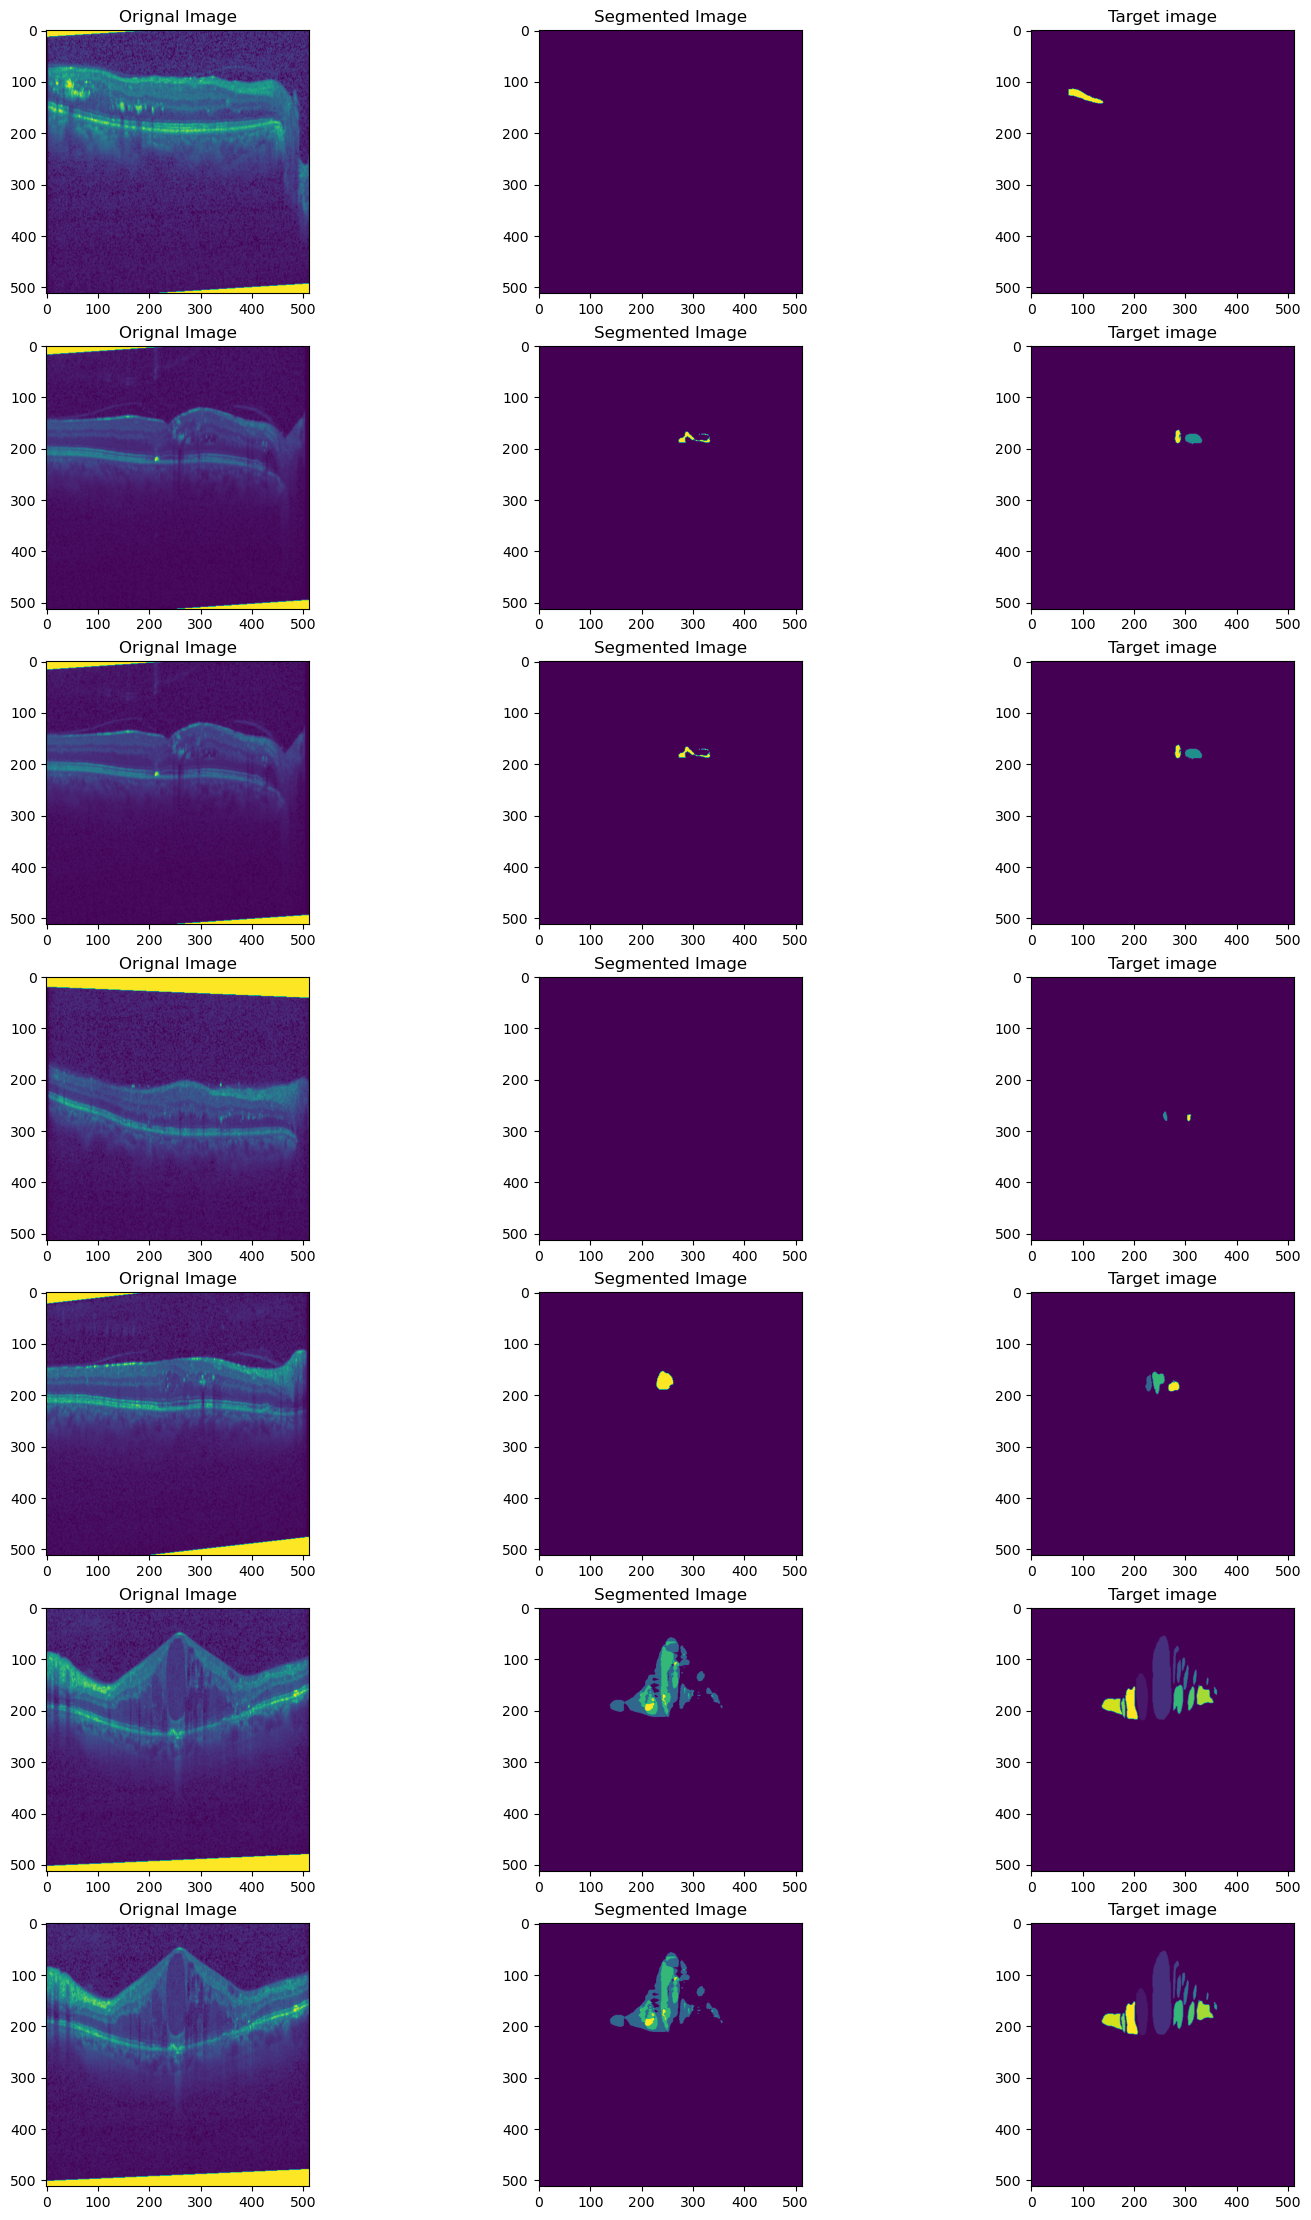

In [45]:
x_val = torch.tensor([])
y_val = torch.tensor([])
for index in test_indices:
    image = OCT.images[index].unsqueeze(0)
    x_val = torch.cat((x_val, image))
    target = OCT.masks[index].unsqueeze(0)
    y_val = torch.cat((y_val, target))
    
print(x_val.size())
print(y_val.size())
plot_examples(x_val, y_val)

## Unet Analysis

In [91]:
import numpy as np 
import pandas as pd 
import os
import numpy as np
import pandas as pd
import scipy.io
from skimage.transform import resize
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
gc.collect()

29722

In [92]:
input_path = os.path.join('/kaggle/input/soidme/Dataset/2015_BOE_Chiu')
subject_path = [os.path.join(input_path, 'Subject_0{}.mat'.format(i)) for i in range(1, 10)] + [os.path.join(input_path, 'Subject_10.mat')]

data_indexes = [10, 15, 20, 25, 28, 30, 32, 35, 40, 45, 50]

width = 284
height = 284
width_out = 196
height_out = 196

In [93]:
mat = scipy.io.loadmat(subject_path[0])
img_tensor = mat['images']
manual_fluid_tensor_1 = mat['manualFluid1']

img_array = np.transpose(img_tensor, (2, 0, 1))
manual_fluid_array = np.transpose(manual_fluid_tensor_1, (2, 0, 1))

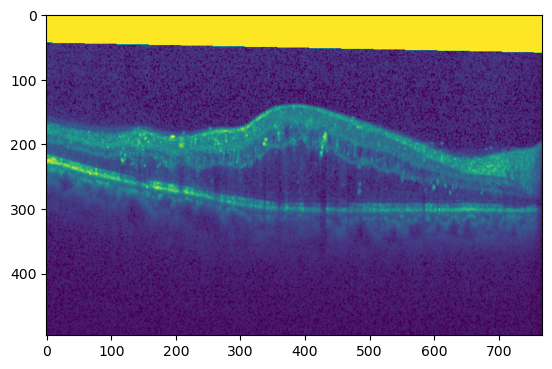

In [94]:
plt.imshow(img_array[25])

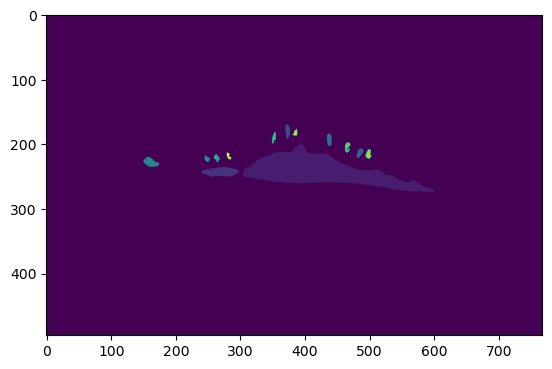

In [95]:
plt.imshow(manual_fluid_array[25])

In [96]:
def thresh(x):
    if x == 0:
        return 0
    else:
        return 1

thresh = np.vectorize(thresh, otypes=[np.float])

def create_dataset(paths):
    x = []
    y = []
    
    for path in tqdm(paths):
        mat = scipy.io.loadmat(path)
        img_tensor = mat['images']
        fluid_tensor = mat['manualFluid1']
        
        img_array = np.transpose(img_tensor, (2, 0 ,1)) / 255
        img_array = resize(img_array, (img_array.shape[0], width, height))
        fluid_array = np.transpose(fluid_tensor, (2, 0 ,1))
        fluid_array = thresh(fluid_array)
        fluid_array  = resize(fluid_array, (fluid_array .shape[0], width_out, height_out))

        for idx in data_indexes:
            x += [np.expand_dims(img_array[idx], 0)]
            y += [np.expand_dims(fluid_array[idx], 0)]
    return np.array(x), np.array(y)

x_train, y_train = create_dataset(subject_path[:9])
x_val, y_val = create_dataset(subject_path[9:])

/tmp/ipykernel_28/2162917096.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  thresh = np.vectorize(thresh, otypes=[np.float])
100%|██████████| 1/1 [00:12<00:00, 12.47s/it]


In [97]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((99, 1, 284, 284), (99, 1, 196, 196), (11, 1, 284, 284), (11, 1, 196, 196))

In [98]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import trange
from time import sleep
use_gpu = torch.cuda.is_available()

In [99]:
batch_size = 9
epochs = 1000
epoch_lapse = 50
threshold = 0.5
sample_size = None

In [100]:
class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=3):
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                )
        return block
    
    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
                    )
            return  block
    
    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    )
            return  block
    
    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        #Encode
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=64)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(64, 128)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(128, 256)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        self.bottleneck = torch.nn.Sequential(
                            torch.nn.Conv2d(kernel_size=3, in_channels=256, out_channels=512),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.Conv2d(kernel_size=3, in_channels=512, out_channels=512),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
                            )
        self.conv_decode3 = self.expansive_block(512, 256, 128)
        self.conv_decode2 = self.expansive_block(256, 128, 64)
        self.final_layer = self.final_block(128, 64, out_channel)
        
    def crop_and_concat(self, upsampled, bypass, crop=False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)
    
    def forward(self, x):
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        bottleneck1 = self.bottleneck(encode_pool3)
        decode_block3 = self.crop_and_concat(bottleneck1, encode_block3, crop=True)
        cat_layer2 = self.conv_decode3(decode_block3)
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2, crop=True)
        cat_layer1 = self.conv_decode2(decode_block2)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1, crop=True)
        final_layer = self.final_layer(decode_block1)
        return  final_layer

In [101]:
def train_step(inputs, labels, optimizer, criterion):
    optimizer.zero_grad()
    outputs = unet(inputs)
    outputs = outputs.permute(0, 2, 3, 1) 
    outputs = outputs.resize(batch_size*width_out*height_out, 2)
    labels = labels.resize(batch_size*width_out*height_out)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    return loss

In [102]:
learning_rate = 0.01
unet = UNet(in_channel=1,out_channel=2)
if use_gpu:
    unet = unet.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(unet.parameters(), lr = 0.01, momentum=0.99)

In [103]:
def get_val_loss(x_val, y_val):
    x_val = torch.from_numpy(x_val).float()
    y_val = torch.from_numpy(y_val).long()
    if use_gpu:
        x_val = x_val.cuda()
        y_val = y_val.cuda()
    m = x_val.shape[0]
    outputs = unet(x_val)
    outputs = outputs.permute(0, 2, 3, 1)
    outputs = outputs.resize(m*width_out*height_out, 2)
    labels = y_val.resize(m*width_out*height_out)
    loss = F.cross_entropy(outputs, labels)
    return loss.data

In [104]:
epoch_iter = np.ceil(x_train.shape[0] / batch_size).astype(int)
t = trange(epochs, leave=True)
for _ in t:
    total_loss = 0
    for i in range(epoch_iter):
        batch_train_x = torch.from_numpy(x_train[i * batch_size : (i + 1) * batch_size]).float()
        batch_train_y = torch.from_numpy(y_train[i * batch_size : (i + 1) * batch_size]).long()
        if use_gpu:
            batch_train_x = batch_train_x.cuda()
            batch_train_y = batch_train_y.cuda()
        batch_loss = train_step(batch_train_x , batch_train_y, optimizer, criterion)
        total_loss += batch_loss
    if (_+1) % epoch_lapse == 0:
        val_loss = get_val_loss(x_val, y_val)
        print(f"Total loss in epoch {_+1} : {total_loss / epoch_iter} and validation loss : {val_loss}")

  0%|          | 0/1000 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
  5%|▌         | 50/1000 [03:46<1:13:54,  4.67s/it]

Total loss in epoch 50 : 0.6255048513412476 and validation loss : 0.5231757760047913


 10%|█         | 100/1000 [07:37<1:10:10,  4.68s/it]

Total loss in epoch 100 : 0.5679057240486145 and validation loss : 0.5980092287063599


 15%|█▌        | 150/1000 [11:28<1:06:11,  4.67s/it]

Total loss in epoch 150 : 0.3973295986652374 and validation loss : 0.4191056489944458


 20%|██        | 200/1000 [15:19<1:02:22,  4.68s/it]

Total loss in epoch 200 : 0.26514729857444763 and validation loss : 0.7043506503105164


 25%|██▌       | 250/1000 [19:11<58:26,  4.68s/it]  

Total loss in epoch 250 : 0.3851008415222168 and validation loss : 0.528475284576416


 30%|███       | 300/1000 [23:01<54:32,  4.68s/it]

Total loss in epoch 300 : 0.2550378441810608 and validation loss : 0.32366201281547546


 35%|███▌      | 350/1000 [26:52<50:40,  4.68s/it]

Total loss in epoch 350 : 0.25208044052124023 and validation loss : 0.3632088601589203


 40%|████      | 400/1000 [30:43<46:43,  4.67s/it]

Total loss in epoch 400 : 0.2534262537956238 and validation loss : 0.24362851679325104


 45%|████▌     | 450/1000 [34:34<42:48,  4.67s/it]

Total loss in epoch 450 : 0.28030654788017273 and validation loss : 0.3731279671192169


 50%|█████     | 500/1000 [38:25<38:58,  4.68s/it]

Total loss in epoch 500 : 0.25991442799568176 and validation loss : 0.4863114356994629


 55%|█████▌    | 550/1000 [42:16<35:01,  4.67s/it]

Total loss in epoch 550 : 0.2589046359062195 and validation loss : 0.5476993322372437


 60%|██████    | 600/1000 [46:07<31:11,  4.68s/it]

Total loss in epoch 600 : 0.2458634227514267 and validation loss : 0.4145808219909668


 65%|██████▌   | 650/1000 [49:58<27:17,  4.68s/it]

Total loss in epoch 650 : 0.24468392133712769 and validation loss : 0.3986966013908386


 70%|███████   | 700/1000 [53:49<23:23,  4.68s/it]

Total loss in epoch 700 : 0.24708959460258484 and validation loss : 0.32247623801231384


 75%|███████▌  | 750/1000 [57:40<19:31,  4.69s/it]

Total loss in epoch 750 : 0.2427721917629242 and validation loss : 0.3614831268787384


 80%|████████  | 800/1000 [1:01:31<15:35,  4.68s/it]

Total loss in epoch 800 : 0.23938259482383728 and validation loss : 0.36919865012168884


 85%|████████▌ | 850/1000 [1:05:23<11:41,  4.67s/it]

Total loss in epoch 850 : 0.2359938621520996 and validation loss : 0.8235544562339783


 90%|█████████ | 900/1000 [1:09:14<07:47,  4.68s/it]

Total loss in epoch 900 : 0.23204371333122253 and validation loss : 0.7407802939414978


 95%|█████████▌| 950/1000 [1:13:05<03:53,  4.67s/it]

Total loss in epoch 950 : 0.2304261177778244 and validation loss : 0.8717942833900452


100%|██████████| 1000/1000 [1:16:56<00:00,  4.62s/it]

Total loss in epoch 1000 : 0.2291906177997589 and validation loss : 0.9620808362960815


In [105]:
gc.collect()

10

In [106]:
def plot_examples(datax, datay, num_examples=3):
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(18,4*num_examples))
    m = datax.shape[0]
    for row_num in range(num_examples):
        image_indx = np.random.randint(m)
        image_arr = unet(torch.from_numpy(datax[image_indx:image_indx+1]).float().cuda()).squeeze(0).detach().cpu().numpy()
        ax[row_num][0].imshow(np.transpose(datax[image_indx], (1,2,0))[:,:,0])
        ax[row_num][0].set_title("Orignal Image")
        ax[row_num][1].imshow(np.transpose(image_arr, (1,2,0))[:,:,0])
        ax[row_num][1].set_title("Segmented Image")
        ax[row_num][2].imshow(image_arr.argmax(0))
        ax[row_num][2].set_title("Segmented Image localization")
        ax[row_num][3].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,0])
        ax[row_num][3].set_title("Target image")
    plt.show()

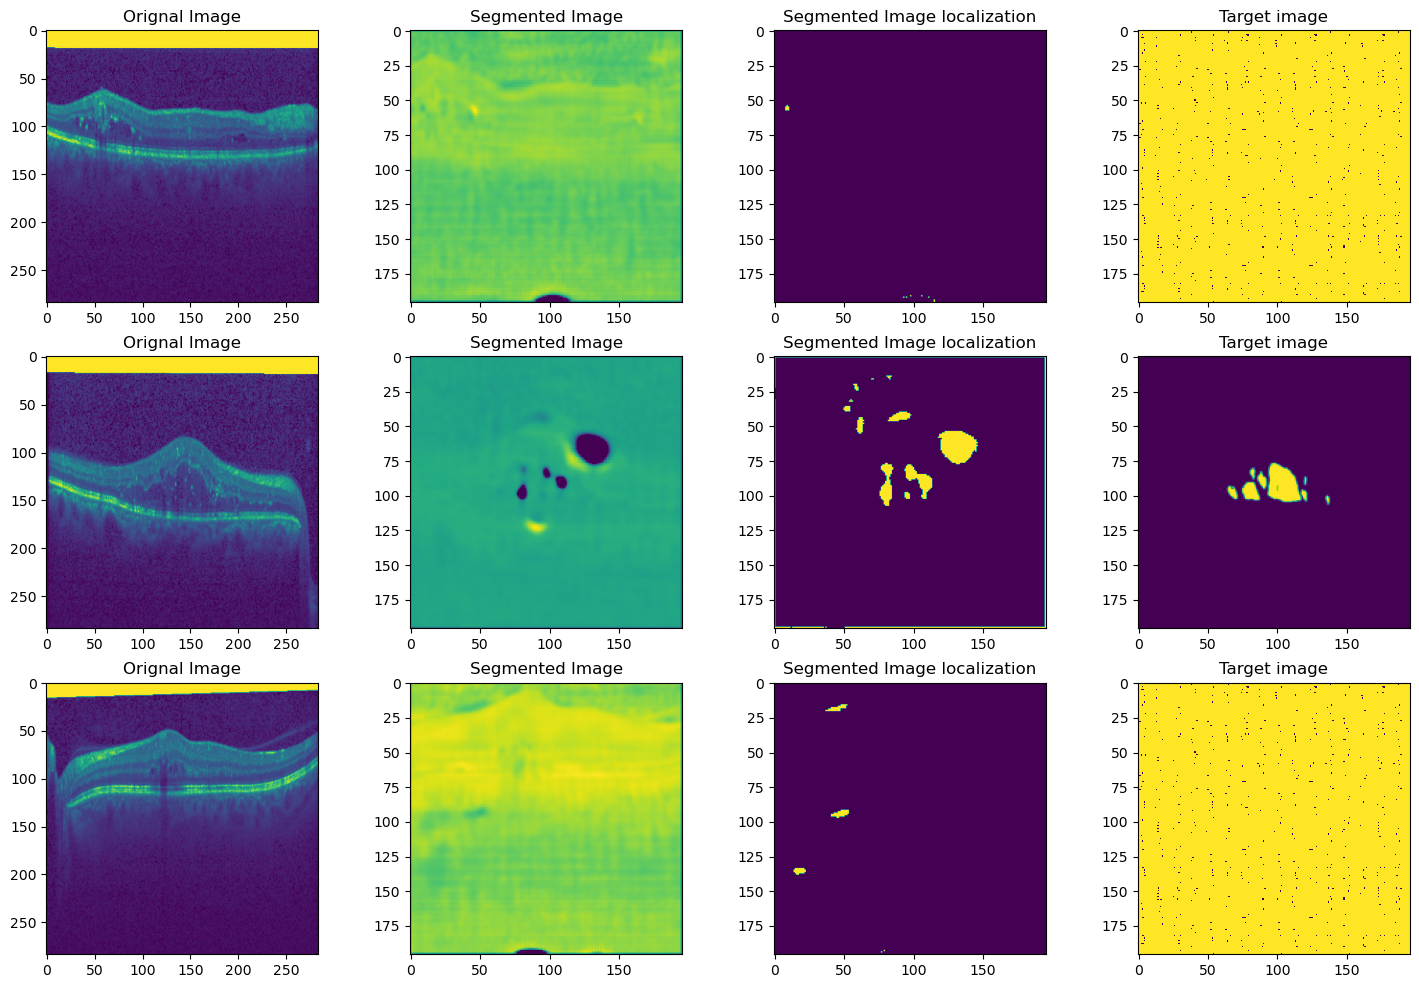

In [107]:
plot_examples(x_train, y_train)

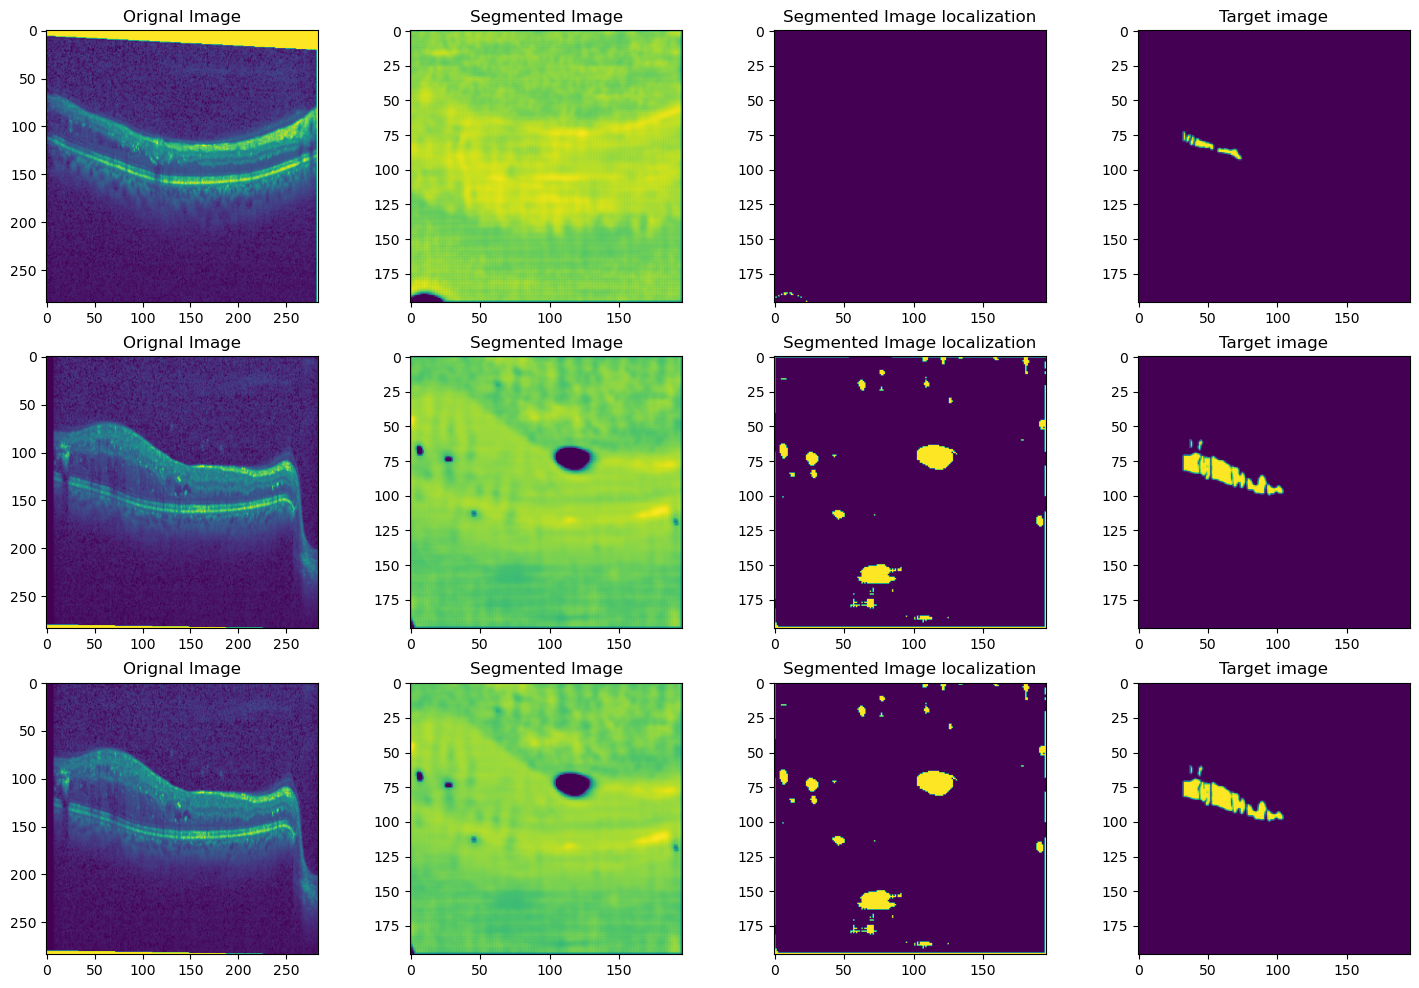

In [108]:
plot_examples(x_val, y_val)

## Modified Pipeline with Unet crafted by mxnet

In [2]:
!pip install mxnet-cu101

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.0/360.0 MB 1.3 MB/s eta 0:00:0000:0100:05
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1


In [3]:
!pip install mxnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 32.3 MB/s eta 0:00:0000:0100:01


In [4]:
import mxnet as mx
num_workers  = mx.context.num_gpus()
if num_workers:
  context = mx.gpu(0)
else:
  context = mx.cpu(0)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
import mxnet as mx
from mxnet import gluon, init, nd, autograd

# Check if GPU is available
if mx.context.num_gpus() > 0:
    context = mx.gpu(0)  # Use the first GPU
else:
    context = mx.cpu(0)  # Use CPU

In [6]:
import mxnet as mx
from mxnet import gluon,init,nd,autograd
mx.random.seed(1)

class network(gluon.nn.HybridBlock):
    def convoluting_part(self,input_channels,output_channels,kernel_size=3):
        shrink_net = gluon.nn.HybridSequential()
        with shrink_net.name_scope():
            shrink_net.add(gluon.nn.Conv2D(in_channels=input_channels,channels=output_channels,kernel_size=kernel_size,activation='relu'))
            shrink_net.add(gluon.nn.BatchNorm(in_channels=output_channels))
            shrink_net.add(gluon.nn.Conv2D(in_channels=output_channels,channels=output_channels,kernel_size=kernel_size,activation='relu'))
            shrink_net.add(gluon.nn.BatchNorm(in_channels=output_channels))
            shrink_net.add(gluon.nn.MaxPool2D(pool_size=(2,2)))  
        return shrink_net
    
    def deconvoluting_part(self,input_channels,hidden_channel,output_channels,kernel_size=3):
        expand_net = gluon.nn.HybridSequential()
        with expand_net.name_scope():
            expand_net.add(gluon.nn.Conv2D(channels=hidden_channel,kernel_size=kernel_size,activation='relu'))
            expand_net.add(gluon.nn.BatchNorm())
            expand_net.add(gluon.nn.Conv2D(channels=hidden_channel,kernel_size=kernel_size,activation='relu'))
            expand_net.add(gluon.nn.BatchNorm())
            expand_net.add(gluon.nn.Conv2DTranspose(channels = output_channels,kernel_size=kernel_size,strides=(2,2),padding=(1,1),output_padding=(1,1)))
        return expand_net        
      
    def plateau_block(self,input_channels,output_channels):
        plateau_net = gluon.nn.HybridSequential()
        with plateau_net.name_scope():
            plateau_net.add(gluon.nn.Conv2D(channels=512,kernel_size=3,activation='relu'))
            plateau_net.add(gluon.nn.BatchNorm())
            plateau_net.add(gluon.nn.Conv2D(channels=512,kernel_size=3,activation='relu'))
            plateau_net.add(gluon.nn.BatchNorm())
            plateau_net.add(gluon.nn.Conv2DTranspose(channels=256,kernel_size=3,strides=(2,2),padding=(1,1),output_padding=(1,1)))
        return plateau_net            
                            
    def output_block(self,input_channels,hidden_channel,output_channels,kernel_size=3):
        x = gluon.nn.HybridSequential()
        with x.name_scope():
            x.add(gluon.nn.Conv2D(in_channels=input_channels,channels=hidden_channel,kernel_size=kernel_size,activation='relu'))
            x.add(gluon.nn.BatchNorm(in_channels=hidden_channel))
            x.add(gluon.nn.Conv2D(in_channels=hidden_channel,channels=hidden_channel,kernel_size=kernel_size,activation='relu'))
            x.add(gluon.nn.BatchNorm(in_channels=hidden_channel))
            x.add(gluon.nn.Conv2D(in_channels=hidden_channel,channels=output_channels,kernel_size=kernel_size,padding=(1,1),activation='relu'))
            x.add(gluon.nn.BatchNorm(in_channels=output_channels))
        return x
    
    def concatenate(self,upsampling_block,conv_block):
        padding = upsampling_block.shape[2]-conv_block.shape[2]
        mid_padding = padding//2
        padded_conv_block = mx.nd.pad(conv_block,mode="edge",pad_width=(0,0,0,0,mid_padding,mid_padding,mid_padding,mid_padding))
        return mx.nd.concat(upsampling_block,padded_conv_block,dim=1)

    
    def __init__(self,input_channels,output_channels,**kwargs):
        super(network,self).__init__(**kwargs)
        # convolving
        self.conv_depth0 = self.convoluting_part(input_channels,output_channels=64)
        self.conv_depth1 = self.convoluting_part(64,128)
        self.conv_depth2 = self.convoluting_part(128,256)
        
        # plateau 
        self.plateau = self.plateau_block(256,512)
        
        # deconvolving
        self.deconv_depth2 = self.deconvoluting_part(512,256,128)
        self.deconv_depth1 = self.deconvoluting_part(256,128,64)
        self.output_layer = self.output_block(128,64,output_channels)
    
    def hybrid_forward(self,F,X):
        conv_block_0 = self.conv_depth0(X)
        conv_block_1 = self.conv_depth1(conv_block_0)
        conv_block_2 = self.conv_depth2(conv_block_1)
        plateau_block_0 = self.plateau(conv_block_2)
        

        deconv_block_2 = self.concatenate(plateau_block_0,conv_block_2)
        concat_block_2 = self.deconv_depth2(deconv_block_2)
        
        deconv_block_1 = self.concatenate(concat_block_2,conv_block_1)
        concat_block_1 = self.deconv_depth1(deconv_block_1)
        
        deconv_block_0 = self.concatenate(concat_block_1,conv_block_0)
        output_layer = self.output_layer(deconv_block_0)
        return output_layer
net = network(input_channels=1,output_channels=2)

In [7]:
import numpy as np
import os
import scipy.io
from skimage.transform import resize
from tqdm import tqdm 

dataset_name = '2015_BOE_Chiu'

def atzero(x):
    a = 0 if x==0 else 1
    return a

atzero = np.vectorize(atzero,otypes=[np.float32])

def create_pipeline(paths,wi,hi,wo,ho,indexes,mat):
    x,y=[],[]
    for file_path in tqdm(paths):
        data = scipy.io.loadmat(file_path)
        images,labels = data['images'],data['manualFluid1']
        transposed_images = np.transpose(images,(2,0,1))/255.0
        resized_images = resize(transposed_images,(transposed_images.shape[0],wi,hi))
        labels = np.transpose(labels,(2,0,1))
        labels = atzero(labels)
        labels = resize(labels,(labels.shape[0],wo,ho))
        
        for index in indexes:
            x = x + [np.expand_dims(resized_images[index],0)]
            y = y + [np.expand_dims(labels[index],0)]
    return np.array(x),np.array(y)

def load_dataset(wi,hi,wo,ho):
    dir_path = '/kaggle/input/soidme/Dataset/2015_BOE_Chiu'
    file_path=[]
    for i in range(1,10):
        file_path.append(os.path.join(dir_path, 'Subject_0{}.mat'.format(i)))
    split = len(file_path)  
    indexes = [10, 15, 20, 25, 28, 30, 32, 35, 40, 45, 50]
    data = scipy.io.loadmat(file_path[0])
    train_features,train_labels = create_pipeline(file_path[:split-1],wi,hi,wo,ho,indexes,data)
    val_features,val_labels = create_pipeline(file_path[split-1:],wi,hi,wo,ho,indexes,data)
    return train_features,train_labels,val_features,val_labels

In [8]:
import mxnet as mx
from mxnet import gluon,nd,autograd,init
from tqdm import trange
from mxnet import metric
def training_step(inputs,labels,optimizer,loss_fn,network,wo,ho,batch_size,flag=0):
    with autograd.record():
        outputs = network(inputs)
        outputs = outputs.transpose((0,2,3,1))
        first_dim = outputs.shape[0]
        outputs = outputs.reshape(first_dim*wo*ho,2)
        labels = labels.reshape(first_dim*wo*ho)
        loss = loss_fn(outputs,labels)
    if flag ==0:
      loss.backward()
      optimizer.step(batch_size)
      return network,loss
    elif flag==1:
      return labels,outputs

def validate(network,data,wo,ho,loss_fn,flag=0):
  _,_,val_X,val_Y = data
  val_X = mx.nd.array(val_X,ctx=context).astype('float32')
  val_Y = mx.nd.array(val_Y,ctx=context).astype('long')
  dim_1  = val_X.shape[0]
  outputs = net(val_X)
  outputs = outputs.reshape(dim_1*wo*ho,2)
  labels = val_Y.reshape(dim_1*wo*ho)
  if flag ==0:
    loss = loss_fn(outputs,labels)
    return loss.mean().asscalar()
  elif flag ==1:
    return labels,outputs

def training_full(network,batch_size,epochs,loss_fn,optimizer,data,wo,ho):
    train_features,train_labels,val_features,val_labels = data
    train_features = mx.nd.array(train_features, ctx=context).astype('float32')
    train_labels = mx.nd.array(train_labels, ctx=context).astype('long')
    val_features = mx.nd.array(val_features, ctx=context).astype('float32')
    val_labels = mx.nd.array(val_labels, ctx=context).astype('long')
    num_epochs = train_features.shape[0]//batch_size
    train_acc = metric.Accuracy()
    val_acc = metric.Accuracy()
    t = trange(epochs, leave=True)
    a = 0
    for e in t:
      for i in range(num_epochs):
        final_loss = 0
        batch_X = mx.nd.array(train_features[i*batch_size:(i+1)*batch_size],ctx=context).astype('float32')
        batch_Y = mx.nd.array(train_labels[i*batch_size:(i+1)*batch_size],ctx=context).astype('long')
        flag=0
        network,loss = training_step(batch_X,batch_Y,optimizer,loss_fn,network,wo,ho,batch_size,flag)
        final_loss +=loss.mean().asscalar()
        flag=1
        l,o = training_step(batch_X,batch_Y,optimizer,loss_fn,network,wo,ho,batch_size,flag)
        train_acc.update(l,o)
      validation_loss = validate(network,data,wo,ho,loss_fn)
      l1,o1 = validate(network,data,wo,ho,loss_fn,flag=1)
      val_acc.update(l1,o1)
    return network, final_loss,train_acc.get()[1],validation_loss,val_acc.get()[1]

In [9]:
(wi,hi),(wo,ho) = (284,284),(196,196)
data=()
data = load_dataset(wi, hi, wo, ho)

100%|██████████| 1/1 [00:08<00:00,  8.04s/it]


In [10]:
print(data[0].shape)
print(data[1].shape)
print(data[2].shape)
print(data[3].shape)
print(num_workers)
print(data[3][0].dtype)

(88, 1, 284, 284)
(88, 1, 196, 196)
(11, 1, 284, 284)
(11, 1, 196, 196)
0
float32


In [11]:
loss_fn = mx.gluon.loss.SoftmaxCrossEntropyLoss()
train_features = data[0]
train_labels = data[1]
val_features = data[2]
val_labels = data[3]
train_features = train_features.astype('float32')
val_features = val_features.astype('float32')
data = train_features,train_labels,val_features,val_labels

In [12]:
print(data[0].shape)

(88, 1, 284, 284)


In [13]:
net = network(input_channels=1,output_channels=2)
net.initialize(init=init.Xavier(), ctx=context)
net.summary(nd.ones((5,1,284,284)))

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (5, 1, 284, 284)               0
        Activation-1                           (5, 64, 282, 282)               0
            Conv2D-2                           (5, 64, 282, 282)             640
         BatchNorm-3                           (5, 64, 282, 282)             256
        Activation-4                           (5, 64, 280, 280)               0
            Conv2D-5                           (5, 64, 280, 280)           36928
         BatchNorm-6                           (5, 64, 280, 280)             256
         MaxPool2D-7                           (5, 64, 140, 140)               0
        Activation-8                          (5, 128, 138, 138)               0
            Conv2D-9                          (5, 128, 138, 138)           73856
        BatchNorm-10        

In [14]:
batch_size = 6
epochs = 100
net = network(input_channels=1,output_channels=2)
net.initialize(init=init.Xavier(),ctx=context)
optimizer =gluon.Trainer(net.collect_params(),optimizer='sgd',optimizer_params={'learning_rate':0.0004})

In [15]:
nnet, loss,acc,validation_loss,validation_accuracy = training_full(net, batch_size, epochs, loss_fn, optimizer, data, wo,ho)

100%|██████████| 100/100 [4:26:12<00:00, 159.73s/it] 


In [16]:
print("Total loss over 100 epochs = ",loss)
train_loss = loss/epochs
print("Mean train loss per epoch = ",train_loss)
print("Training accuracy = ", acc)
print("Validation loss = ", validation_loss)
print("Validation accuracy = ", validation_accuracy)

Total loss over 100 epochs =  3.9221832752227783
Mean train loss per epoch =  0.039221832752227785
Training accuracy =  0.8842226112383729
Validation loss =  0.6901505
Validation accuracy =  0.8812701147249252


In [17]:
unet = network(input_channels=1,output_channels=2)

In [2]:
import matplotlib.pyplot as plt
def show_results(network,features,labels,examples=4):
  figure,axis = plt.subplots(nrows=4,ncols=4,figsize=(15,4*examples))
  dim1 = features.shape[0]
  for row in range(examples):
    img_idx = np.random.randint(dim1)
    image_array = network(mx.nd.array(features[img_idx:img_idx+1],ctx=context).astype('float32')).squeeze(0).asnumpy()
    axis[row][0].imshow(np.transpose(features[img_idx], (1,2,0))[:,:,0])
    axis[row][1].imshow(np.transpose(image_array, (1,2,0))[:,:,0])
    axis[row][2].imshow(image_array.argmax(0))
    axis[row][3].imshow(np.transpose(labels[img_idx], (1,2,0))[:,:,0])
  plt.show()

In [3]:
train_features,train_labels,val_features,val_labels = data
show_results(mynet,train_features,train_labels)

NameError: name 'data' is not defined

In [ ]:
show_results(unet,val_features,val_labels)